---
title: Stat analysis
description: ...
---

### Imports

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display, Markdown, HTML
from datetime import datetime

sns.set_theme(style = 'ticks', palette = 'pastel')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context("paper")
# Define fig saving context
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.directory'] = 'figures'

### Loading data

In [6]:
match_results = pd.read_csv('data/match_results2.csv', parse_dates=['date'])
match_results.shape

(11637, 5)

In [8]:
match_results['win'] = match_results['result'].apply(lambda x: 1 if x == 'win' else 0)
match_results['loss'] = match_results['result'].apply(lambda x: 1 if x == 'loss' else 0)
match_results['draw'] = match_results['result'].apply(lambda x: 1 if x == 'draw' else 0)

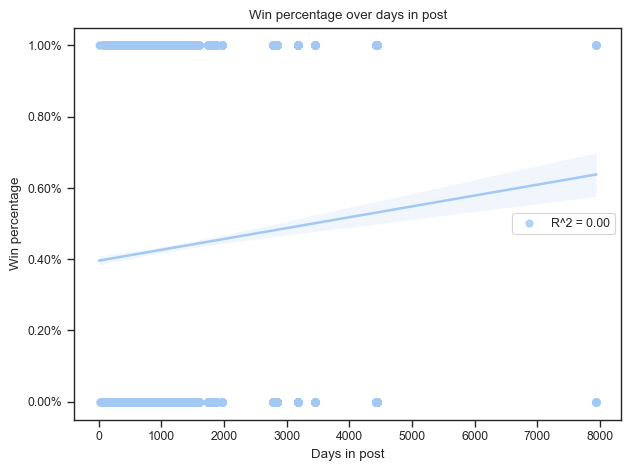

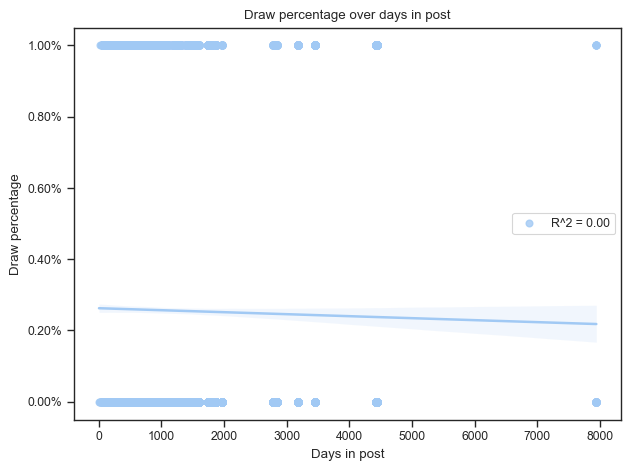

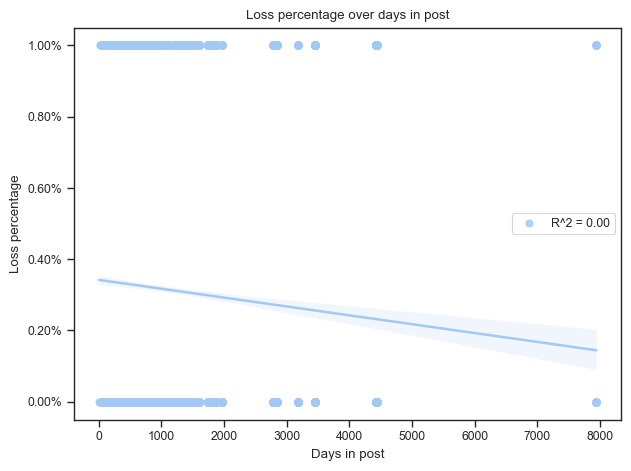

In [12]:
def plot_percentage_over_days(data, y_value, y_label):
    plt.figure()
    sns.regplot(x='days_in_post', y=y_value, data=data)
    
    plt.title(f'{y_label.capitalize()} percentage over days in post')
    plt.xlabel('Days in post')
    plt.ylabel(f'{y_label.capitalize()} percentage')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

    # Calculate R-squared value
    y_pred = np.poly1d(np.polyfit(data['days_in_post'], data[y_value], 1))(data['days_in_post'])
    ss_res = np.sum((data[y_value] - y_pred) ** 2)
    ss_tot = np.sum((data[y_value] - np.mean(data[y_value])) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    plt.legend([f'R^2 = {r2:.2f}'])
    plt.show()

plot_percentage_over_days(match_results, 'win', 'Win')
plot_percentage_over_days(match_results, 'draw', 'Draw')
plot_percentage_over_days(match_results, 'loss', 'Loss')

## Correlation between days in post and teams performance

- could indicate that club keeps their well performing head-coaches
- could indicate that head coaches performance improve after time either because:
    - early low performance : coaches need some time once they are appointed to reach previous team performance
    - long term improvement of performance